# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self,scale = True):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        
        if scale is False:
            ax.set(xlim=plt.xlim, ylim = plt.ylim)
        
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw(scale)
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


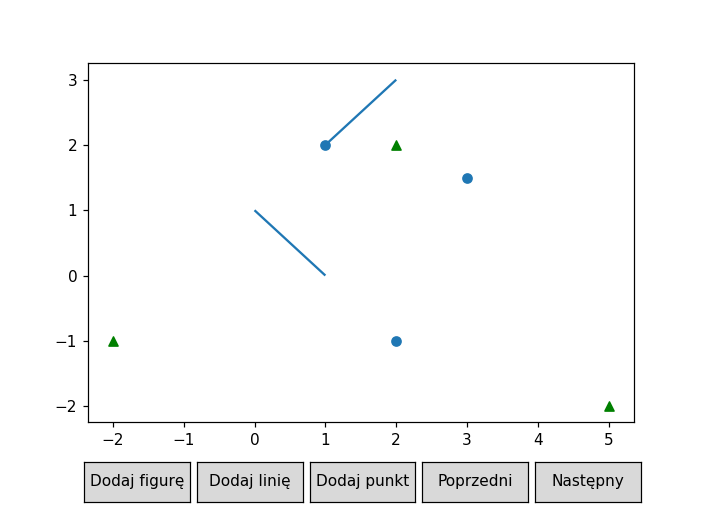

In [3]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


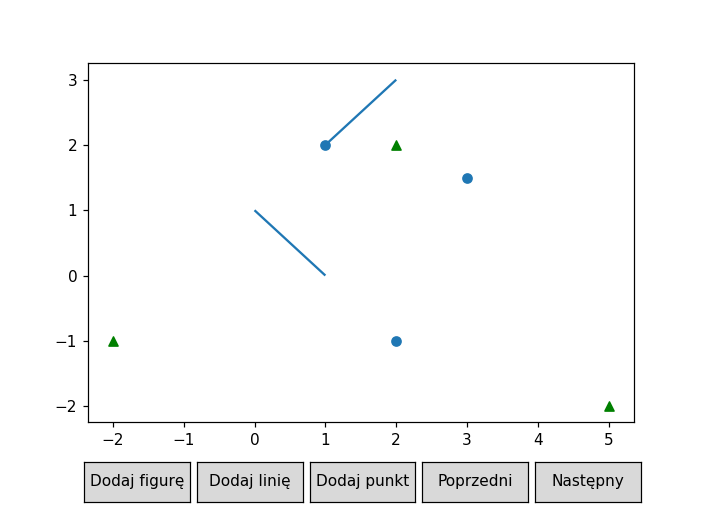

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


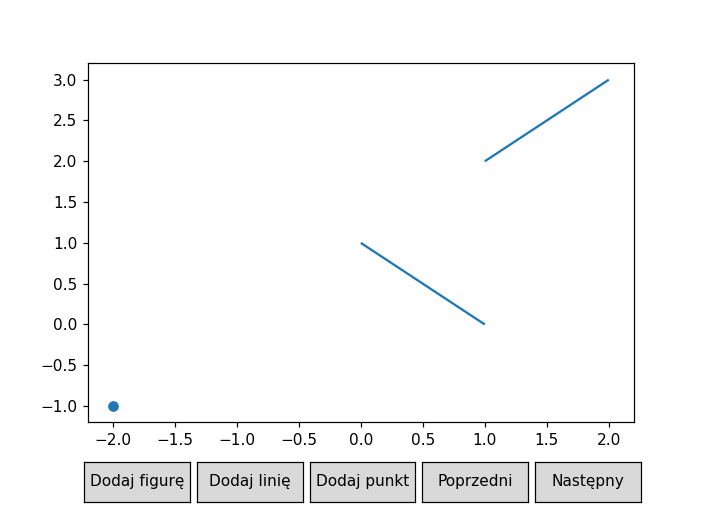

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

### Rozwiązanie

In [6]:
import random
import math
import numpy as np
import copy
from matplotlib import path

In [7]:
def generate_points(n,interval):
    a = interval[0]
    b= interval[1]
    from random import randint
    set_a = [(random.uniform(a,b),random.uniform(a,b)) for _ in range(n)]
    return set_a

In [8]:
def det(a,b,c):
    return a[0]*b[1] + b[0]*c[1] + a[1]*c[0] - c[0]*b[1] - b[0]*a[1] - a[0]*c[1]

In [9]:
def point_inside(p,t):
    e = 10**-12
    det1 = det(t[0],t[1],p)
    det2 = det(t[1],t[2],p)
    det3 = det(t[2],t[0],p)

    return (det1>e and det2>e and det3>e) or (det1<-e and det2<-e and det3<-e)

In [10]:
# TODO: ???

def pointInTriangle6(p, t):
    triangle = path.Path([t[0], t[1], t[2]])
    points = np.array([p[0], p[1]]).reshape(1, 2)
    res = triangle.contains_points(points)
    return res[0]

In [11]:
# sprawdza, czy trójkąty sa takie same

def equals(t1, t2):
    if t1 is None and t2 is None:
        return True
    if t1 is not None and t2 is not None:
        if t1[0] == t2[0] and t1[1] == t2[1] and t1[2] == t2[2] :
            return True
            
    return False

In [12]:
# trójkąt jest "pusty" - nie bierzemy go pod uwagę

def is_empty(t):
    return t == None or (t[0] == None and t[1] == None and t[2] == None)

In [13]:
# środek ciężkości trójkąta

def triangle_center(t):
    return ((t[0][0]+t[1][0]+t[2][0])/3, (t[0][1]+t[1][1]+t[2][1])/3)


# wersor - wektor jednsotkowy, określa kierunek i zwrot wektora danego 2 punktami

def unit_vector(p1, p2):
    v = (p2[0]-p1[0], p2[1]-p1[1])
    
    norm = np.linalg.norm(v)
    
    if abs(norm) < 10**-9:
        return v
    else:
        return v / norm


In [14]:
# odnajduje pierwszy "niepusty" trójkąt aktualnej triangulacji

def first_triangle(triangles):
    for t in triangles:
        if not is_empty(t):
            return t

In [15]:
# sprawdza, czy dany trójkąt był juz odwiedzony

def has_been_visited(t, visited):
    if t == None: return True
    for v in visited:
        if equals(t,v): return True 
    return False

In [16]:
# odszukuje trójkąt zawierający dany punkt, zaczynając od pierwszego trójkąta triangulacji,
# idąc po kolejnych sąsiadach
    
def find_triangle(point, triangles):
    
    def find_triangle_recursive(p, t, lastT):

        count = 0
        visited = []
        index = 0

        while True:
            upStream = False
            count += 1
            if not is_empty(t) and pointInTriangle6(p, t):
                return t

            d1 = float("inf")
            d2 = float("inf")

            t1 = t[3]
            t2 = t[4]
            t3 = t[5]

            if equals(t1, lastT):
                nextT1 = t2
                nextT2 = t3
            else:
                if equals(t2, lastT):
                    nextT1 = t1
                    nextT2 = t3
                else:
                    nextT1 = t1
                    nextT2 = t2

            visitedT1 = has_been_visited(nextT1, visited)
            visitedT2 = has_been_visited(nextT2, visited)

            if not has_been_visited(t, visited):
                visited.append(t)

            if nextT1 == None and nextT2 != None:
                if not visitedT2:
                    t = nextT2
                    continue
                else:
                    upStream = True

            if nextT2 == None and nextT1 != None:
                if not visitedT1:
                    t = nextT1
                    continue
                else:
                    upStream = True

            if not upStream and not is_empty(t):
                herePos   = triangle_center(t)
                targetPos = p
                dir1Pos   = triangle_center(nextT1)
                dir2Pos   = triangle_center(nextT2)
                dir1      = unit_vector(herePos, dir1Pos)
                dir2      = unit_vector(herePos, dir2Pos)
                targetVector = unit_vector(herePos, targetPos)
                dot1 = np.dot(targetVector, dir1)
                dot2 = np.dot(targetVector, dir2)

                if dot1 > dot2 and not visitedT1:
                    lastT = t
                    t = nextT1
                    continue

                if dot2 > dot1 and not visitedT2:
                    lastT = t
                    t = nextT2
                    continue

                if not visitedT1:
                    lastT = t
                    t = nextT1
                    continue

                if not visitedT2:
                    lastT = t
                    t = nextT2
                    continue

            lastT = t
            index -= 1
            if index <= 0:
                index = len(visited)-1
            t = visited[index]

    first = first_triangle(triangles)
    t = find_triangle_recursive(point, first, None)
    return t


In [17]:
def remove_triangle(triangle):

    # usuwamy każdemu z sąsiadów usuwany trójkąt z listy sąsiadów
    for ngh in triangle[3:6]:
        change_ngh(triangle, None, ngh)
        
    for i in range(6):
        triangle[i] = None

# ???
def point_on_line(p, t):
    if on_edge(p, t[0], t[1]):
        return 2
    if on_edge(p, t[1], t[2]):
        return 0
    if on_edge(p, t[2], t[0]):
        return 1
    return -1


# https://en.wikipedia.org/wiki/Delaunay_triangulation
def legal(t, p):
    p1 = t[0]
    p2 = t[1]
    p3 = t[2]
    matrix = np.array(
            [[p1[0],p1[1],p1[0]**2+p1[1]**2,1],
             [p2[0],p2[1],p2[0]**2+p2[1]**2,1],
             [p3[0],p3[1],p3[0]**2+p3[1]**2,1],
             [p[0],p[1],p[0]**2+p[1]**2,1]])

    return np.linalg.det(matrix) <= 0

# sprawdza, czy dane 2 punkty są wierzchołkami trójkąta

def triangle_vertices(p1, p2, t):
    if t is None:
        return False
    return (p1 == t[0] or p1 == t[1] or p1 == t[2]) and (p2 == t[0] or p2 == t[1] or p2 == t[2])


# zwraca sąsiada trójkąta względem krawędzi p1p2

def get_ngh(p1, p2, t):
    for i in range(3):
        if triangle_vertices(p1, p2, t[3+i]):
            return t[3+i]

    return None

In [18]:
# zwraca 3 punkt trójkąta, gdy mamy dane 2 pozostałe

def get_third_point(triangle,p1,p2):
    for i,p in enumerate(triangle):
        if p != p1 and p != p2:
            return p

In [19]:
# sprawdza czy punkt leży na odcinku (danym 2 punktami) - suma odległości punktu od 
# punktów końcowych odcinka musi być równa odległości końców (z dokładnością do eps)

def on_edge(p, p1, p2, eps = 10**-9):
    dist1 = dist(p, p1)
    dist2 = dist(p, p2)
    dist3 = dist(p1,p2)
    return abs((dist1 + dist2) - dist3) < eps

In [20]:
def legalize(triangles, t):
    nextT = get_ngh(t[1], t[2], t)

    if nextT == None:
        return triangles

    p = get_third_point(nextT,t[1],t[2])
    
    if not legal(t, p):

        t1 = [t[0], t[1], p, get_ngh(t[0], t[1], t), get_ngh(t[1], p, nextT)]
        t2 = [t[0], p, t[2], get_ngh(t[0], t[2], t), get_ngh(t[2], p, nextT), t1]

        t1.append(t2)

        change_ngh(t, t1, t1[3])
        change_ngh(nextT, t1, t1[4])

        change_ngh(t, t2, t2[3])
        change_ngh(nextT, t2, t2[4])

        remove_triangle(t)
        remove_triangle(nextT)

        triangles.append(t1)
        triangles.append(t2)

        triangles = legalize(triangles, t1)
        triangles = legalize(triangles, t2)
    return triangles

In [21]:
def change_ngh(fromT, toT, t):
    for i in range(3,6):
        if fromT != None and t != None and t[i] != None and equals(t[i], fromT):
            t[i] = toT
            break

def find_ngh_with_point(point, t):
    for i in range(3, 6):
        if t != None and t[i] != None and point_inside(point, t[i]):
            return t[i]

In [22]:
# wstawia kolejny punkt do triangulacji 

def insert_point(point, triangles):
    
    # odszukujemy trójkąt zawierający dany punkt, sprawdzamy, czy leży wewnątrz niego czy na krawędzi
    t = find_triangle(point, triangles)
    line = point_on_line(point, t)

    if line == -1:

        t1 = [point, t[0], t[1], get_ngh(t[0], t[1], t)]
        t2 = [point, t[1], t[2], get_ngh(t[1], t[2], t), t1]
        t3 = [point, t[2], t[0], get_ngh(t[2], t[0], t), t1, t2]

        change_ngh(t, t1, t1[3])
        change_ngh(t, t2, t2[3])
        change_ngh(t, t3, t3[3])

        t2.append(t3)
        t1.append(t2)
        t1.append(t3)

        triangles.append(t1)
        triangles.append(t2)
        triangles.append(t3)

        remove_triangle(t)


        # legalizacja każdego z nowych trójkątów powstałych w wyniku podziału
        for t in (t1,t2,t3):
            triangles = legalize(triangles, t)

    else:
        t2 = find_ngh_with_point(point, t)

        if t2 == None:
            return triangles

        line2 = point_on_line(point, t2)

        tt1 = [point, t[line], t[(line+1)%3],
               get_ngh(t[line], t[(line+1)%3], t)]
        tt2 = [point, t[(line+2)%3], t[line],
               get_ngh(t[(line+2)%3], t[line], t), tt1]

        tt3 = [point, t2[line2], t2[(line2+1)%3],
               get_ngh(t2[line2], t2[(line2+1)%3], t2)]
        tt4 = [point, t2[(line2+2)%3], t2[line2],
               get_ngh(t2[(line2+2)%3], t2[line2], t2), tt3]

        tt1.append(tt2)
        tt3.append(tt4)

        change_ngh(t,  tt1, tt1[3])
        change_ngh(t,  tt2, tt2[3])
        change_ngh(t2, tt3, tt3[3])
        change_ngh(t2, tt4, tt4[3])

        if get_ngh(point, t[(line+1)%3], tt3) != None:
            tt1.append(get_ngh(point, t[(line+1)%3], tt3))
            tt2.append(get_ngh(point, t[(line+2)%3], tt4))
        else:
            tt1.append(get_ngh(point, t[(line+1)%3], tt4))
            tt2.append(get_ngh(point, t[(line+2)%3], tt3))

        if get_ngh(point, t2[(line2+1)%3], tt1) != None:
            tt3.append(get_ngh(point, t2[(line2+1)%3], tt1))
            tt4.append(get_ngh(point, t2[(line2+2)%3], tt2))
        else:
            tt3.append(get_ngh(point, t2[(line2+1)%3], tt2))
            tt4.append(get_ngh(point, t2[(line2+2)%3], tt1))

        triangles.append(tt1)
        triangles.append(tt2)
        triangles.append(tt3)
        triangles.append(tt4)

        remove_triangle(t)
        remove_triangle(t2)

        for t in (tt1,tt2,tt3,tt4):
            triangles = legalize(triangles, t)

    return triangles

In [23]:
def triangulate(points):
    
    # najdalsza współrzędna 
    m1 = abs(max(points, key = lambda a: a[0])[0])
    m2 = abs(min(points, key = lambda a: a[0])[0])
    m3 = abs(max(points, key = lambda a: a[1])[1])
    m4 = abs(min(points, key = lambda a: a[1])[1])

    Max = max(max(m1,m2),max(m3,m4))

    
    # trójkąt jako [p1,p2,p3,ngh1,ngh2,ngh3]
    
    # trójkąt, wewnątrz którego znajdują się wszystkie dane punkty
    super_triangle = [(3*Max,0), (0,3*Max),(-3*Max,-3*Max), None, None, None]
    
    triangles = []
    triangles.append(super_triangle)
    
    for point in points:
        triangles = insert_point(point, triangles)
        
    return triangles,Max


In [24]:
# sprawdza, czy trójkąt mieści się w danym zakresie

def triangle_out_of_scope(t, minX, minY, maxX, maxY):
    
    if is_empty(t):
        return True
    
    for point in t[:3]:
        if point[0] > maxX or point[1] > maxY or point[0] < minX or point[1] < minY:
            return True
        
    return False
    

In [25]:
# usuwamy trójkąty zawierające dodane punkty (poza zakresem)

def get_result_points(triangles, minX, minY, maxX, maxY):
    result = []
    for t in triangles:
        if not triangle_out_of_scope(t, minX, minY, maxX, maxY):
            triangle = [t[0],t[1],t[2], t[3], t[4], t[5]]
            for i in range(3,6):
                if triangle_out_of_scope(triangle[i], minX, minY, maxX, maxY):
                    triangle[i] = None
            result.append(triangle)
            
    return result

In [26]:
def delaunay(points):
    triangles,Max = triangulate(points)
    
    return get_result_points(triangles, 0, 0, Max, Max)


In [27]:
# konwersja trójkąta danego 3 punktami na odcinki (jego boki)

def triangles_to_lines(triangles):
    # każda krawędź maksymalnie raz
    lines = set()
    
    for t in triangles:
        if t[0] != None:
            if not (t[1],t[0]) in lines: 
                lines.add((t[0],t[1]))
            if not (t[2],t[1]) in lines: 
                lines.add((t[1],t[2]))
            if not (t[0],t[2]) in lines:
                lines.add((t[2],t[0]))
    return lines

In [28]:
# https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points?fbclid=IwAR2THXafz_TgKEfPpPuq4YnHrANNj17lxbkVWtMs0emioIWgW6_9q8Dzt4c

# środek okręgu opisanego na danym trójkącie

def center_of_circumcircle(p1,p2,p3):
    point1 = complex(p1[0],p1[1])
    point2 = complex(p2[0],p2[1])
    point3 = complex(p3[0],p3[1])

    w = (point3 - point1)/(point2 - point1)
    c = (point2 - point1)*(w - abs(w)**2)/(2j*w.imag)+point1


    center = (c.real,c.imag)
    return center

In [29]:
# zwraca krawędzi "zewnętrzne" danego trójkąta - nie mające sąsiedniego trójkąta

def find_edges_without_ngh(triangle):
    ngh = []
    for t in triangle[3:6]:
        if t != None:
            ngh.append(t)
    a = triangle[0]
    b = triangle[1]
    c = triangle[2]
    
    # idx: 0 - ab, 1 - bc, 2 - ca
    exists = [False]*3
    
    # dla każdego sąsiedniego trójkąta sprawdzamy, która krawędź jest wspólna z danym trójkątem
    for n in ngh:
        vertices = n[:3]
        if a in vertices and b in vertices:
            exists[0] = True
        if b in vertices and c in vertices:
            exists[1] = True
        if c in vertices and a in vertices:
            exists[2] = True
            
    without = []
    With = []
    if not exists[0]:
        without.append((a,b))
    else:
        With.append((a,b))
    if not exists[1]:
        without.append((b,c))
    else:
        With.append((b,c))
    if not exists[2]:
        without.append((c,a))
    else:
        With.append((c,a))
        
    return without,With

In [30]:
# środek odcinka (zadanego jako 2 punkty do nieg należące)
def middle_point(p1,p2):
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]
    
    return ((x1 + x2)/2, (y1 + y2)/2)

In [31]:
# punkt przecięcia odcinków (zadanych jako 2 punkty do nich należące)

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [32]:
# crosses mówi, czy odcinek center-mid przecina bok trójkąta

def frame_cross(upper_right, lower_left,center,mid,center_inside,crosses = False):
    
    # frame lines (start and end points)
    left = [lower_left, (lower_left[0],upper_right[1])]
    right = [upper_right, (upper_right[0],lower_left[1])]
    
    if center_inside or (not center_inside and crosses):
        xdiff = center[0] - mid[0]
    else:
        xdiff = mid[0] - center[0]
    
    if xdiff <= 0 :
        cross = line_intersection(left,[center,mid])
    else:
        cross = line_intersection(right,[center,mid])
          
    return cross

In [49]:
def voronoi_diagram(triangles, upper_right, lower_left):
      
    voronoi_edges = set()
    centers = set()
    
    for t in triangles:
        c1 = center_of_circumcircle(t[0],t[1],t[2])
        centers.add(c1)
        
        # załatwione krawędzi zewnętrzne w danym trójkącie
        found_outer_edges = False
        
        for i in range(3,6):
            ngh = t[i]
            
            # łączymy środki okręgów opisanych na sąsiadujących trójkątach
            if ngh != None:
                c2 = center_of_circumcircle(ngh[0],ngh[1],ngh[2])
                centers.add(c2)
                if (c2,c1) not in voronoi_edges:
                    voronoi_edges.add((c1,c2))
             
            # tworzymy odpowiednią półprostą od środka okręgu opisanego na danym trójkącie "na zewnątrz"
            elif ngh == None and not found_outer_edges:
                edges,with_ngh = find_edges_without_ngh(t)
                
                    
                for i in range(len(edges)):
                    edge = edges[i]
                    mid = middle_point(edge[0],edge[1])
                    
                    on_line1 = False
                    on_line11 = False
                    on_line2 = False
                    on_line22 = False
                    
                    if len(edges) == 2:
                        
                        # sprawdzamy, czy odcinek mid-center przecina drugi lub trzeci bok trójkąta 
                        intersection1 = line_intersection(edges[(i+1)%2], (mid,c1))
                        on_line1 = on_edge(intersection1, edges[(i+1)%2][0], edges[(i+1)%2][1])
                        on_line11 = on_edge(intersection1, mid, c1)
                        
                        intersection2 = line_intersection(with_ngh[0], (mid,c1))
                        on_line2 = on_edge(intersection2, with_ngh[0][0], with_ngh[0][1])
                        on_line22 = on_edge(intersection2, mid, c1)
                        
                        
                    elif len(edges) == 1:
                        intersection1 = line_intersection(with_ngh[0], (mid,c1))
                        on_line1 = on_edge(intersection1, with_ngh[0][0], with_ngh[0][1])
                        on_line11 = on_edge(intersection1, mid, c1)

                        intersection2 = line_intersection(with_ngh[1], (mid,c1))
                        on_line2 = on_edge(intersection2, with_ngh[1][0], with_ngh[1][1])
                        on_line22 = on_edge(intersection2, mid, c1)
                      
                    
                    if (on_line1 and on_line11) or (on_line2 and on_line22):
                        cross = frame_cross(upper_right, lower_left,c1,mid,point_inside(c1,t),True)
                        
                    else:
                        cross = frame_cross(upper_right, lower_left,c1,mid,point_inside(c1,t))

                    
                    if (cross,c1) not in voronoi_edges:
                        voronoi_edges.add((c1,cross))
                    
                found_outer_edges = True
                 
    return list(centers),voronoi_edges
        

### Ex 1

In [50]:
points = [(59.248885018139376, 63.59633397198213), (9.153198942140827, 74.68494049843531), (36.03311452290562, 18.062889829984762), (43.11508694112408, 24.531661093175906), (58.10467300070107, 69.37960851235412), (87.5536111991444, 57.146403637135315), (88.78800556693778, 72.76794194059862), (44.056976722532184, 3.677984618529262), (69.40836706754119, 26.522710287442752), (62.7382036524048, 38.559320289962294), (66.29689508257476, 94.4045916372774), (52.25136238182224, 37.895995087143255), (94.49747194901832, 86.39108652785369), (5.266899911283851, 2.9607548854299504)]
tr = delaunay(points)
l = triangles_to_lines(tr)

<IPython.core.display.Javascript object>


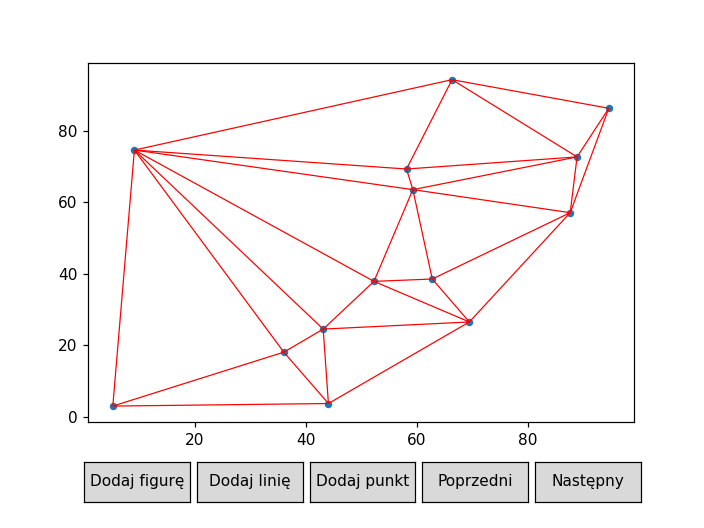

In [51]:
plot = Plot(points = [PointsCollection(points, s=15)],lines = [LinesCollection(l,color = "red", linewidth = 0.8)])
# plt.xlim = (-10,110)
# plt.ylim = (-10,110)
# plot.draw(False)
plot.draw()

In [52]:
centers,vor_edges = voronoi_diagram(tr,(-10,-10),(110,110))

<IPython.core.display.Javascript object>


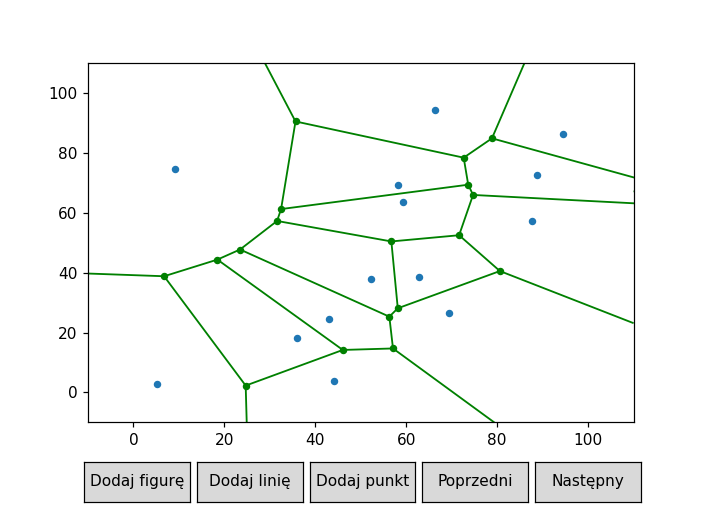

In [53]:
plot = Plot(points = [PointsCollection(points, s=15), PointsCollection(centers, s=15, color = "green")],
            lines = [LinesCollection(vor_edges,color = "green", linewidth = 1.2)])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()

<IPython.core.display.Javascript object>


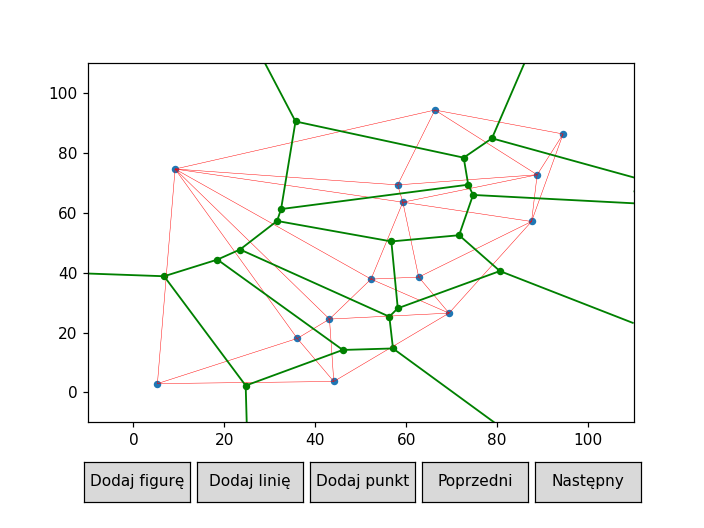

In [54]:
plot = Plot(points = [PointsCollection(points, s=15),
                     PointsCollection(centers, s=15, color = "green")],
            lines = [LinesCollection(l,color = "red", linewidth = 0.3),
                     LinesCollection(vor_edges,color = "green", linewidth = 1.2)
                    ])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()

### Ex 2

<IPython.core.display.Javascript object>


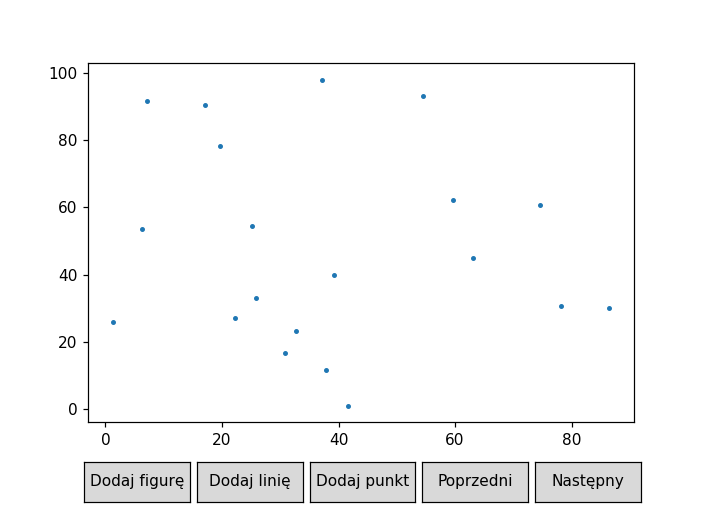

In [55]:
points2 = generate_points(20, [0,100])
plot = Plot(points = [PointsCollection(points2, s=5)])
plot.draw()

In [40]:
tr2 = delaunay(points2)
l2 = triangles_to_lines(tr2)

centers2,vor_edges2 = voronoi_diagram(tr2,(-10,-10),(110,110))

<IPython.core.display.Javascript object>


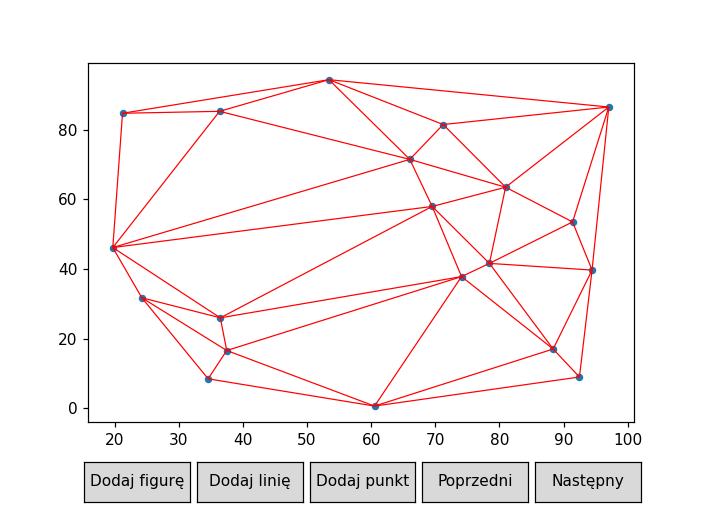

In [41]:
plot = Plot(points = [PointsCollection(points2, s=15)],lines = [LinesCollection(l2,color = "red", linewidth = 0.8)])
# plt.xlim = (-10,110)
# plt.ylim = (-10,110)
# plot.draw(False)
plot.draw()

<IPython.core.display.Javascript object>


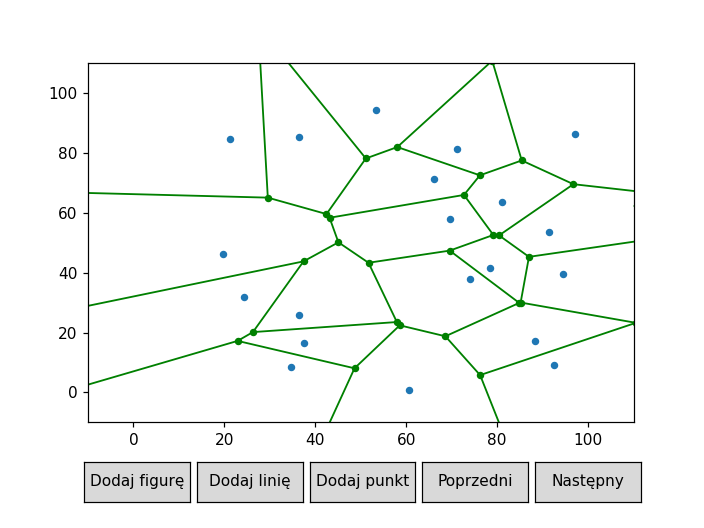

In [42]:
plot = Plot(points = [PointsCollection(points2, s=15), PointsCollection(centers2, s=15, color = "green")],
            lines = [LinesCollection(vor_edges2,color = "green", linewidth = 1.2)])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()

<IPython.core.display.Javascript object>


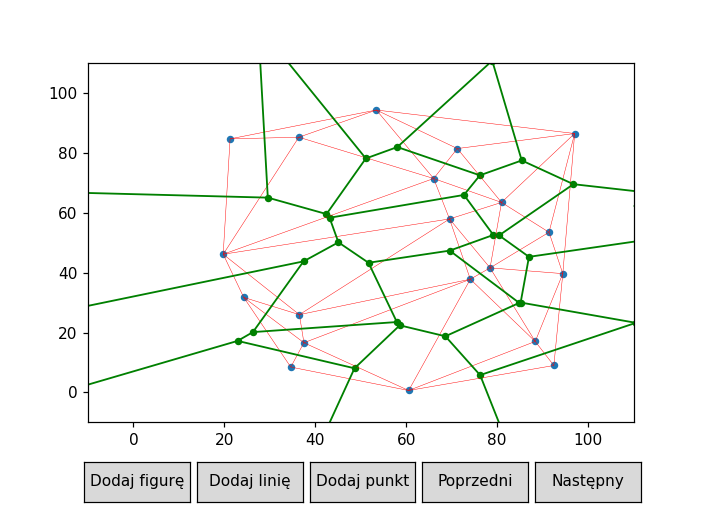

In [43]:
plot = Plot(points = [PointsCollection(points2, s=15), PointsCollection(centers2, s=15, color = "green")],
            lines = [LinesCollection(l2,color = "red", linewidth = 0.3),
                     LinesCollection(vor_edges2,color = "green", linewidth = 1.2)])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()

### Ex 3

<IPython.core.display.Javascript object>


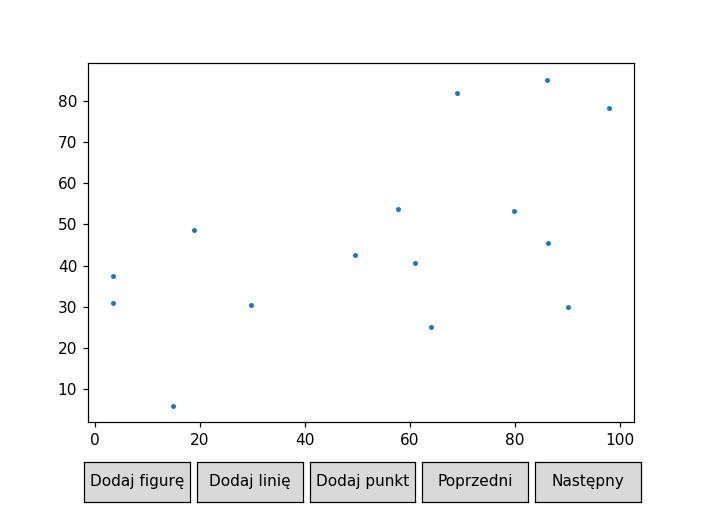

In [44]:
points3 = generate_points(15, [0,100])
plot = Plot(points = [PointsCollection(points3, s=5)])
plot.draw()

In [45]:
tr3 = delaunay(points3)
l3 = triangles_to_lines(tr3)

centers3,vor_edges3 = voronoi_diagram(tr3,(-10,-10),(110,110))

<IPython.core.display.Javascript object>


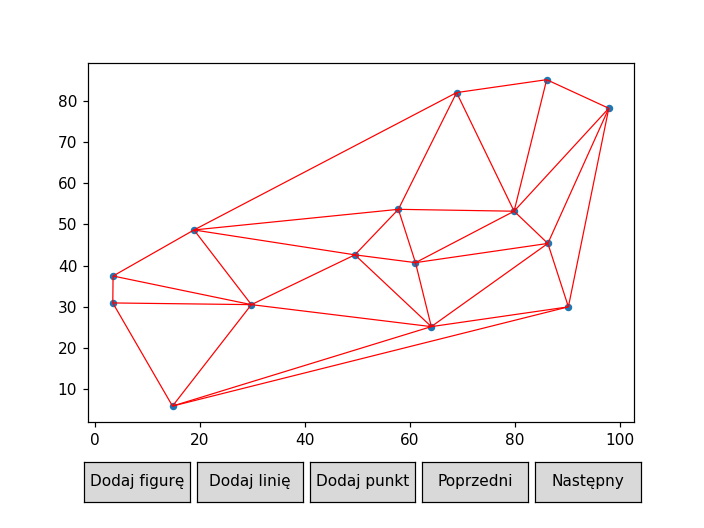

In [46]:
plot = Plot(points = [PointsCollection(points3, s=15)],lines = [LinesCollection(l3,color = "red", linewidth = 0.8)])
# plt.xlim = (-10,110)
# plt.ylim = (-10,110)
# plot.draw(False)
plot.draw()

<IPython.core.display.Javascript object>


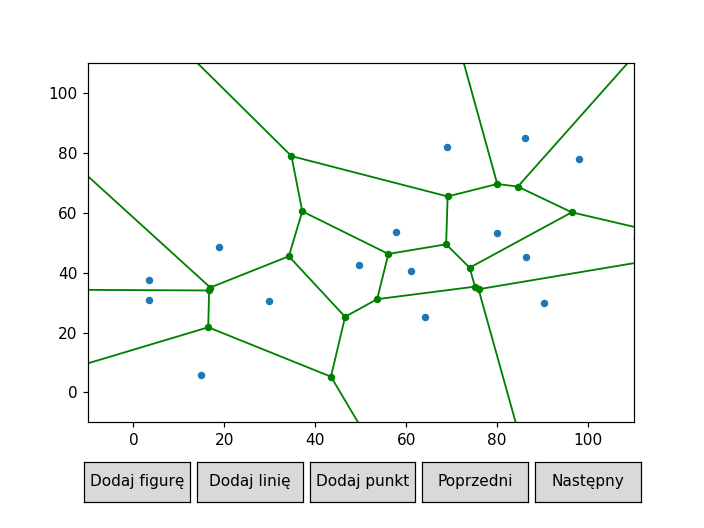

In [47]:
plot = Plot(points = [PointsCollection(points3, s=15), PointsCollection(centers3, s=15, color = "green")],
            lines = [LinesCollection(vor_edges3,color = "green", linewidth = 1.2)])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()